# Exploring `build_renewable_profiles` outputs

The code below initialise the to be used packages. Further, `_sets_path_to_root` makes sure that we set the path to your pypsa-africa folder which we need for reading files. Please, also make sure you set up the `toast` environment which is shared as `environment-max.yml` in the envs folder.

In [1]:
import atlite
import cartopy.crs as ccrs
import xarray as xr
import geopandas as gpd
import holoviews as hv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import pypsa
import shutil
from rasterio.plot import show
from atlite.gis import shape_availability, ExclusionContainer

import os
import sys
sys.path.append('../')  # to import helpers
from scripts._helpers import _sets_path_to_root
_sets_path_to_root("pypsa-africa")


plt.rcParams['figure.figsize'] = [7, 7]
%matplotlib inline

This is the repository path:  /home/max/OneDrive/PHD-Flexibility/07_pypsa-africa/0github/pypsa-africa/pypsa-africa
Had to go 1 folder(s) up.


## Let's open the profiles
The `build_renewable_profiles` for each technology are stored in the `resources` folder. We read first the path and open then with xarray the .nc file. As you can see there is quite a lot data available.  What you should note is that only the `potential` is grided (can be shown in a nice raster on a map). From the `profiles` we can only retrieve timeseries data without mapping it.

In [2]:
res_t_path = os.path.realpath("resources")+"/profile_solar.nc"
res_t = xr.open_dataset(res_t_path)

In [3]:
res_t

<xarray.Dataset>
Dimensions:           (time: 8760, bus: 735, y: 257, x: 291)
Coordinates:
  * time              (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
  * bus               (bus) object '4358' '4359' '4360' ... '15128' '15130'
  * y                 (y) float64 -37.5 -37.2 -36.9 -36.6 ... 38.7 39.0 39.3
  * x                 (x) float64 -19.5 -19.2 -18.9 -18.6 ... 66.9 67.2 67.5
Data variables:
    profile           (time, bus) float64 ...
    weight            (bus) float64 ...
    p_nom_max         (bus) float64 ...
    potential         (y, x) float64 ...
    average_distance  (bus) float64 ...

### The renewable potential in [MW] per cutout.

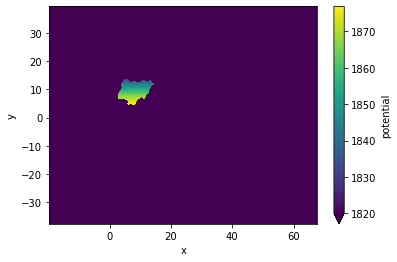

In [4]:
res_t["potential"].plot(vmin=1820, vmax=res_t.potential[:].max())

Let's zoom-in. For that purpose we needs the boundaries, in this case of Nigeria. With `geopandas` we retrieve the geographic shapes (in vector format) for Nigeria and read the shape boundaries.

[ 2.69170169  4.24059418 14.57717777 13.86592398]


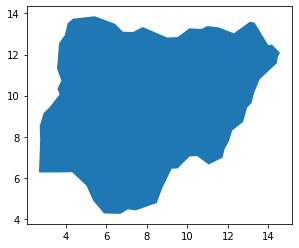

In [5]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = world.query('continent == "Africa"')
countries = ["Nigeria"] # "Niger"]
shapes = world[world.name.isin(countries)].set_index('name')


import math

# For showing cutouts in Africa
# shapes = africa
shapes.plot();
print(shapes.total_bounds)
latmin, lonmin, latmax, lonmax = shapes.total_bounds

#latmin, lonmin, latmax, lonmax = math.floor(latmin), math.ceil(lonmin), math.floor(latmax), math.ceil(lonmax)

Now we need to add the boundaries to the plot. Note that we also adjusted the y-scale to better show the difference accross the regions.

In [6]:
res_t = res_t.sel(x=np.arange(latmin,latmax,0.01), y=np.arange(lonmin,lonmax,0.01), method="nearest")

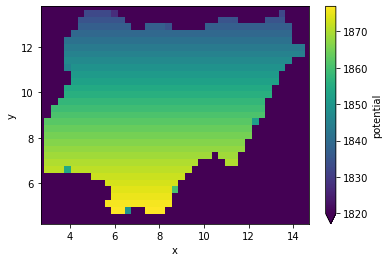

In [7]:
res_t["potential"].plot(vmin=1820, vmax=res_t.potential[:].max())
# ax.set_xlim(0,20)
# ax.set_ylim(0,10)

## Timeseries
Timeseris plots are helpful to analyse the seasonality and general variability. Below we show how you could plot some of these.

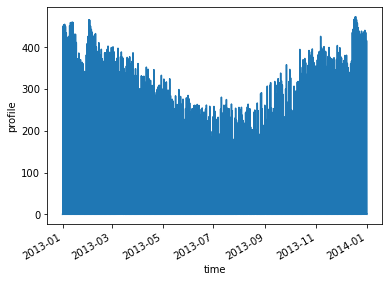

In [8]:
res_t['profile'].sum(dim='bus').plot()

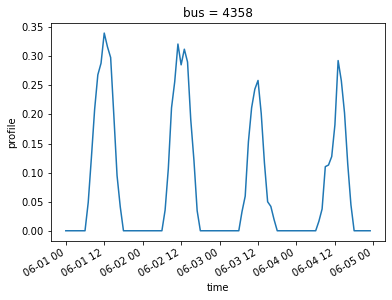

In [9]:
res_t['profile'].sel(bus="4358", time=slice("2013-06-01", "2013-06-4")).plot()

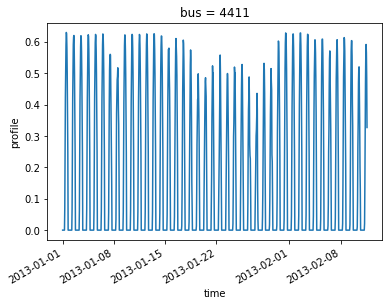

In [ ]:
res_t["profile"].isel(bus=sum(range(10)), time=range(0,1000)).plot()

## Open hydro profile and plot

In [28]:
res_t_path_h = os.path.realpath("resources")+"/profile_hydro.nc"
res_h = xr.open_dataset(res_t_path_h)

C:\ProgramData\Miniconda3\envs\toast\lib\site-packages\IPython\core\pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


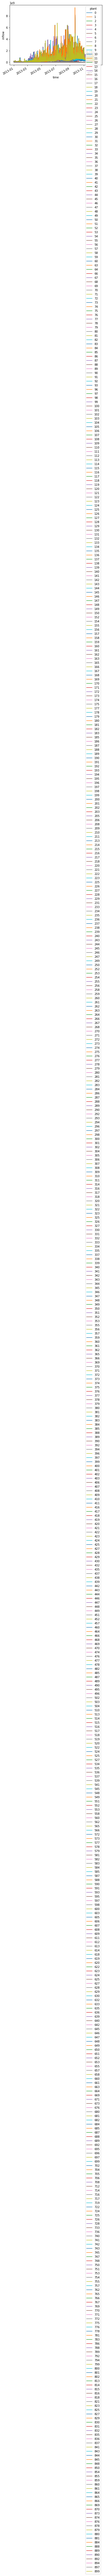

In [29]:
res_h.inflow.plot.line(x="time")